In [2]:
import sys, os
import os
import torch
import torchvision.transforms as transforms

home_dir = os.path.abspath(os.getcwd()+"/../../")
print(home_dir)
sys.path.append(os.path.join(home_dir, 'lib'))
sys.path.append(home_dir)

from lib.models.backbones.vit import ViT
from lib.models.heads import UncertaintyDeconvDepthWiseChannelHead
from lib.models.heads import TopdownHeatmapSimpleHead
from lib.dataset.coco import COCODataset
from lib.core.config import config
from lib.core.config import update_config
from lib.models.extra.vit_huge_uncertainty_config import extra

from lib.models.uncertainty_pose import UncertaintyPose

from lib.utils.vis import display_heatamp, display_keypoints, display_keypoints_with_uncertainty, coco_info
import cv2
import numpy as np


torch.cuda.is_available()

update_config(home_dir + '/experiments/coco/vit/vit_huge_uncertainty.yaml')


/home/juju/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/juju/juhan_ws/HPE/visualAI-HPE


## Load dataset

In [3]:
config.DATASET.TARGET_KEYPOINT = True
config.DATASET.TARGET_HEATMAP = True
config.TEST.USE_GT_BBOX = True

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

# train_dataset = COCODataset(
#     cfg=config, 
#     root=home_dir + '/data/coco/', 
#     image_set='train2017', 
#     is_train=True,
#     transform=transforms.Compose(
#         [
#             transforms.ToTensor(),
#         ]
#     ),
# )

# train_loader = torch.utils.data.DataLoader(
#     train_dataset,
#     batch_size=1,
#     shuffle=True,
#     num_workers=config.WORKERS,
#     pin_memory=True,
# )

test_dataset = COCODataset(
    cfg=config, 
    root=home_dir + '/data/coco/', 
    image_set='val2017', 
    is_train=False,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    ),
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=config.WORKERS,
    pin_memory=True,
)



loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
=> num_images: 5000
=> load 6352 samples


## Load model

In [4]:
## Backbone - ViT
backbone = ViT(
    img_size=extra["backbone"]["img_size"],
    patch_size=extra["backbone"]["patch_size"],
    embed_dim=extra["backbone"]["embed_dim"],
    in_channels=3,
    num_heads=extra["backbone"]["num_heads"],
    depth=extra["backbone"]["depth"],
    qkv_bias=True,
    drop_path_rate = extra["backbone"]["drop_path_rate"]
)

## HEAD - Heatmap Simple Head
deconv_head = TopdownHeatmapSimpleHead(
    in_channels=extra["keypoint_head"]["in_channels"],
    num_deconv_layers=extra["keypoint_head"]["num_deconv_layers"],
    num_deconv_filters=extra["keypoint_head"]["num_deconv_filters"],
    num_deconv_kernels=extra["keypoint_head"]["num_deconv_kernels"],
    extra=dict(final_conv_kernel=1),
    out_channels=17,
)

## Uncertainty head
uncertainty_head = UncertaintyDeconvDepthWiseChannelHead(
    extra["uncertainty_channel_head"], norm_cfg=dict(type="BN")
)
model = UncertaintyPose(backbone, deconv_head, uncertainty_head, config)


model.eval()
model = model.cuda()

In [6]:
from lib.core.inference import post_dark_udp
from lib.core.inference import get_final_preds

def get_max_preds(heatmaps):
    """
    get predictions from score maps+
    heatmaps: numpy.ndarray([batch_size, num_joints, height, width])
    """
    assert isinstance(heatmaps, np.ndarray), "heatmaps should be numpy.ndarray"
    assert heatmaps.ndim == 4, "batch_images should be 4-ndim"
    N, K, _, W = heatmaps.shape
    heatmaps_reshaped = heatmaps.reshape((N, K, -1))
    idx = np.argmax(heatmaps_reshaped, 2).reshape((N, K, 1))
    maxvals = np.amax(heatmaps_reshaped, 2).reshape((N, K, 1))

    preds = np.tile(idx, (1, 1, 2)).astype(np.float32)
    preds[:, :, 0] = preds[:, :, 0] % W
    preds[:, :, 1] = preds[:, :, 1] // W

    preds = np.where(np.tile(maxvals, (1, 1, 2)) > 0.0, preds, -1)
    return preds, maxvals


## Load model

In [5]:
checkpoint_path = home_dir + "/checkpoints/vit_huge_uncertainty_77_1_AP.pth.tar"
model = model.custom_init_weights(model, checkpoint_path)

print() 

checkpoint path :  /home/juju/juhan_ws/HPE/visualAI-HPE/checkpoints/vit_huge_uncertainty_77_1_AP.pth.tar
Succesfully init weights..



## Get uncertainty in COCO2017 test dataset 

In [7]:
num_samples = len(test_dataset)
all_preds = np.zeros((num_samples, config.MODEL.NUM_JOINTS, 3), dtype=np.float32)
all_preds_exp = np.zeros((num_samples, config.MODEL.NUM_JOINTS, 3), dtype=np.float32)
all_boxes = np.zeros((num_samples, 6))
image_path = []
filenames = []
imgnums = []
bbox_ids = []
uncertainty_preds=np.zeros((num_samples, config.MODEL.NUM_JOINTS, 1), dtype=np.float32)
gt_visibility_flag=np.zeros((num_samples, config.MODEL.NUM_JOINTS, 1), dtype=np.float32)

idx = 0
soft_plus = torch.nn.Softplus()

with torch.no_grad():
    # for i, (input, target, target_weight, meta) in enumerate(val_loader):
    for i, (input, target, target_weight, heatmap, heatmap_target, meta) in enumerate(
        test_loader
    ):  
        # output_heatmap = model_freeze.forward(input.cuda())
        output_heatmap = model.forward(input.cuda())
        if config.LOSS.UNCERTAINTY:
            pred_keys, uncertainty, output_norm_heatmap, output_heatmap = output_heatmap

        uncertainty_map = soft_plus(uncertainty)
        if uncertainty.shape[-2:] == output_heatmap.shape[-2:]:
            if config.LOSS.USE_INDEXING:
                # kp_ = np.round(target.detach().cpu().numpy() / 4)
                # keypoint max version
                if not config.MODEL.USE_EXP_KP:
                    kp_, _ = get_max_preds(output_heatmap.detach().cpu().numpy())
                    kp_ = post_dark_udp(kp_, output_heatmap.detach().cpu().numpy(), kernel=11)
                    pred_keys = torch.from_numpy(kp_).cuda()
                    kp_ = np.round(kp_)
                else:
                    kp_ = np.round(pred_keys.detach().cpu().numpy())

                x = np.clip(kp_[:, :, 0], 0, config.MODEL.HEATMAP_SIZE[0] - 1)
                y = np.clip(kp_[:, :, 1], 0, config.MODEL.HEATMAP_SIZE[1] - 1)

                # Uncertainty Map has 1 channel
                sigma_x = torch.diagonal(
                    uncertainty_map[:, 0, y, x], dim1=0, dim2=1
                ).permute(1, 0)

                uncertainty = torch.cat(
                    [sigma_x.unsqueeze(-1), sigma_x.unsqueeze(-1)], dim=-1
                )

        num_images = input.size(0)

        c = meta["center"].numpy()
        s = meta["scale"].numpy()
        score = meta["score"].numpy()

        # Can add adaptive kp prediction /
        preds, maxvals = get_final_preds(config, output_heatmap.clone().cpu().numpy(), c, s, 11)
        all_preds[idx : idx + num_images, :, 0:2] = preds[:, :, 0:2]
        all_preds[idx : idx + num_images, :, 2:3] = maxvals
        uncertainty_preds[idx : idx + num_images, :, 0] = uncertainty[:,:,0].cpu().numpy()
        gt_visibility_flag[idx : idx + num_images, :, 0] = target_weight
        # double check this all_boxes parts
        all_boxes[idx : idx + num_images, 0:2] = c[:, 0:2]
        all_boxes[idx : idx + num_images, 2:4] = s[:, 0:2]
        all_boxes[idx : idx + num_images, 4] = np.prod(s * 200, 1)
        all_boxes[idx : idx + num_images, 5] = score

        # print(preds[:, :, 0:2].shape, uncertainty[:,:,0].cpu().numpy().shape)
        image_path.extend(meta["image"])
        bbox_ids.extend(meta["bbox_id"])
        idx += num_images

        if i % config.PRINT_FREQ == 0:
            msg = (
                "Test: [{0}/{1}]\t".format(
                    i, len(test_loader), 
                )
            )


### Evaluate accuracy between uncertainty and G.T. visualization flag 

In [8]:
from copy import deepcopy

uncertainty_thresh_0_8_product = (deepcopy(uncertainty_preds) / 0.8).reshape(-1)
uncertainty_thresh_0_8_product = np.where(uncertainty_thresh_0_8_product > 1, 0,1)
uncertainty_thresh_1_0_product = (deepcopy(uncertainty_preds) / 1.0).reshape(-1)
uncertainty_thresh_1_0_product = np.where(uncertainty_thresh_1_0_product > 1, 0,1)
uncertainty_thresh_1_2_product = (deepcopy(uncertainty_preds) / 1.2).reshape(-1)
uncertainty_thresh_1_2_product = np.where(uncertainty_thresh_1_2_product > 1, 0,1)
uncertainty_thresh_1_5_product = (deepcopy(uncertainty_preds) / 1.5).reshape(-1)
uncertainty_thresh_1_5_product = np.where(uncertainty_thresh_1_5_product > 1, 0,1)
uncertainty_thresh_1_9_product = (deepcopy(uncertainty_preds) / 1.9).reshape(-1)
uncertainty_thresh_1_9_product = np.where(uncertainty_thresh_1_9_product > 1, 0,1)
uncertainty_thresh_2_0_product = (deepcopy(uncertainty_preds) / 2).reshape(-1)
uncertainty_thresh_2_0_product = np.where(uncertainty_thresh_2_0_product > 1, 0,1)
uncertainty_thresh_2_5_product = (deepcopy(uncertainty_preds) / 2.5).reshape(-1)
uncertainty_thresh_2_5_product = np.where(uncertainty_thresh_2_5_product > 1, 0,1)
uncertainty_thresh_3_0_product = (deepcopy(uncertainty_preds) / 3).reshape(-1)
uncertainty_thresh_3_0_product = np.where(uncertainty_thresh_3_0_product > 1, 0,1)
uncertainty_thresh_5_0_product = (deepcopy(uncertainty_preds) / 5).reshape(-1)
uncertainty_thresh_5_0_product = np.where(uncertainty_thresh_5_0_product > 1, 0,1)


division_num = 2
uncertainty_thresh_1_0 = (deepcopy(uncertainty_preds) / division_num).reshape(-1)
uncertainty_thresh_1_0 = np.where(uncertainty_thresh_1_0 >= (1/division_num), 0, 1 - uncertainty_thresh_1_0)
uncertainty_thresh_1_2 = (deepcopy(uncertainty_preds) / division_num).reshape(-1)
uncertainty_thresh_1_2 = np.where(uncertainty_thresh_1_2 >= (1.2/division_num), 0, 1 - uncertainty_thresh_1_2)
uncertainty_thresh_1_5 = (deepcopy(uncertainty_preds) / division_num).reshape(-1)
uncertainty_thresh_1_5 = np.where(uncertainty_thresh_1_5 >= (1.5/division_num), 0, 1 - uncertainty_thresh_1_5)
uncertainty_thresh_2_0 = (deepcopy(uncertainty_preds) / division_num).reshape(-1)
uncertainty_thresh_2_0 = np.where(uncertainty_thresh_2_0 >= (2/division_num), 0, 1- uncertainty_thresh_2_0)
uncertainty_thresh_3_0 = (deepcopy(uncertainty_preds) / division_num).reshape(-1)
uncertainty_thresh_3_0 = np.where(uncertainty_thresh_3_0 >= 1, 0, 1 - uncertainty_thresh_3_0)
uncertainty_thresh_5_0 = (deepcopy(uncertainty_preds) / division_num).reshape(-1)
uncertainty_thresh_5_0 = np.where(uncertainty_thresh_5_0 >= (5/division_num), 0, 1 - uncertainty_thresh_5_0)

vis_1_non_vis_0 = deepcopy(gt_visibility_flag).reshape(-1)

In [12]:
print((np.sum(uncertainty_thresh_0_8_product * vis_1_non_vis_0)+ np.sum((uncertainty_thresh_0_8_product+1)%2 * (vis_1_non_vis_0+1)%2) ) / len(vis_1_non_vis_0))
print((np.sum(uncertainty_thresh_1_0_product * vis_1_non_vis_0)+ np.sum((uncertainty_thresh_1_0_product+1)%2 * (vis_1_non_vis_0+1)%2) ) / len(vis_1_non_vis_0))
print((np.sum(uncertainty_thresh_1_2_product * vis_1_non_vis_0)+ np.sum((uncertainty_thresh_1_2_product+1)%2 * (vis_1_non_vis_0+1)%2) ) / len(vis_1_non_vis_0))
print((np.sum(uncertainty_thresh_1_5_product * vis_1_non_vis_0)+ np.sum((uncertainty_thresh_1_5_product+1)%2 * (vis_1_non_vis_0+1)%2) ) / len(vis_1_non_vis_0), "best uncertainty threshold 1.5")
print((np.sum(uncertainty_thresh_1_9_product * vis_1_non_vis_0)+ np.sum((uncertainty_thresh_1_9_product+1)%2 * (vis_1_non_vis_0+1)%2) ) / len(vis_1_non_vis_0))
print((np.sum(uncertainty_thresh_2_0_product * vis_1_non_vis_0)+ np.sum((uncertainty_thresh_2_0_product+1)%2 * (vis_1_non_vis_0+1)%2) ) / len(vis_1_non_vis_0))
print((np.sum(uncertainty_thresh_2_5_product * vis_1_non_vis_0)+ np.sum((uncertainty_thresh_2_5_product+1)%2 * (vis_1_non_vis_0+1)%2) ) / len(vis_1_non_vis_0))
print((np.sum(uncertainty_thresh_3_0_product * vis_1_non_vis_0)+ np.sum((uncertainty_thresh_3_0_product+1)%2 * (vis_1_non_vis_0+1)%2) ) / len(vis_1_non_vis_0))
print((np.sum(uncertainty_thresh_5_0_product * vis_1_non_vis_0)+ np.sum((uncertainty_thresh_5_0_product+1)%2 * (vis_1_non_vis_0+1)%2) ) / len(vis_1_non_vis_0))

0.7860423766483924
0.7932564083567936
0.7958216032004741
0.7969236183138243 best uncertainty threshold 1.5
0.7948399762927841
0.794154689583642
0.7894317676692844
0.7822825603793154
0.7304230256334272


### Check Precision & Recall in uncertainty 

uncertainty prediction mAP : 0.8586

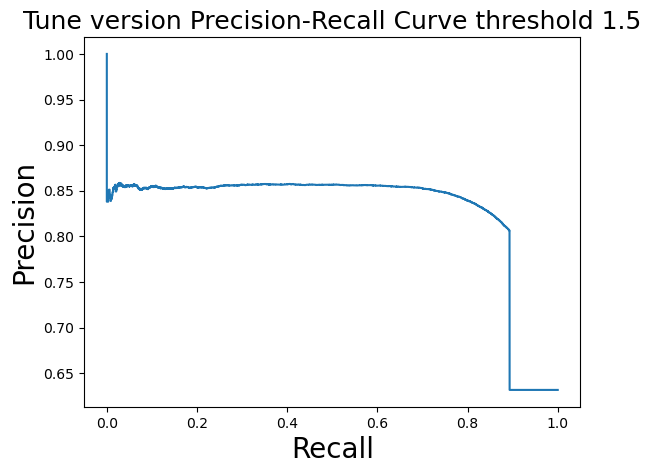

(0.6317139576233516, 0.8586619406291538)

In [16]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
import matplotlib.pyplot as plt 
# 정밀도와 재현율 계산
precision_1_5, recall_1_5, _ = precision_recall_curve(vis_1_non_vis_0, uncertainty_thresh_1_5)

# 정밀도-재현율 곡선 그리기
disp = PrecisionRecallDisplay(precision=precision_1_5, recall=recall_1_5)
disp.plot()

plt.xlabel('Recall',size = 20)
plt.ylabel('Precision',size = 20)
plt.title('Tune version Precision-Recall Curve threshold 1.5',size=18)
plt.show()


precision_1_5_mean = np.mean(precision_1_5)

precision_1_5[0],np.max(precision_1_5[:-5])